# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

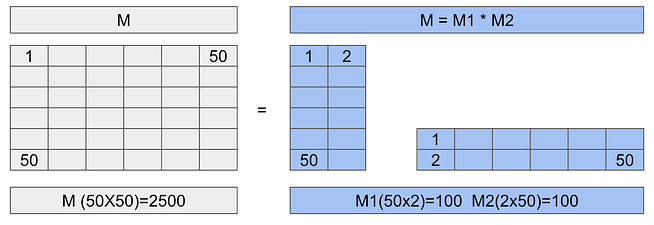

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [3]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [4]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


["I want you to act as a motivational coach.  You can do this by telling your students that they are not alone in their struggles, and then encouraging them.\nIf you're going through the same thing with someone else's kids or parents who have been struggling for years now (or even decades), it's time"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
import pandas as pd

df = pd.read_csv("hf://datasets/fka/awesome-chatgpt-prompts/prompts.csv")


df_tokenized = df.copy()
df_tokenized['input_ids'] = df['prompt'].apply(lambda x: tokenizer(x)['input_ids'])
df_tokenized['attention_mask'] = df['prompt'].apply(lambda x: tokenizer(x)['attention_mask'])

train_sample = df_tokenized.head(50)

train_sample = train_sample.drop('act', axis=1, errors='ignore')

display(train_sample)

,prompt,input_ids,attention_mask
0,Imagine you are an experienced Ethereum develo...,"[186402, 1152, 1306, 660, 72560, 28857, 167625...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"Using WebPilot, create an outline for an artic...","[39312, 15202, 51, 46712, 15, 7932, 660, 67606...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,I want you to act as a linux terminal. I will ...,"[44, 4026, 1152, 427, 1769, 661, 267, 104105, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"I want you to act as an English translator, sp...","[44, 4026, 1152, 427, 1769, 661, 660, 7165, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,I want you to act as an interviewer. I will be...,"[44, 4026, 1152, 427, 1769, 661, 660, 33322, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,I want you to act as a javascript console. I w...,"[44, 4026, 1152, 427, 1769, 661, 267, 49760, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,I want you to act as a text based excel. you'l...,"[44, 4026, 1152, 427, 1769, 661, 267, 5484, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,I want you to act as an English pronunciation ...,"[44, 4026, 1152, 427, 1769, 661, 660, 7165, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,I want you to act as a spoken English teacher ...,"[44, 4026, 1152, 427, 1769, 661, 267, 93949, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,I want you to act as a travel guide. I will wr...,"[44, 4026, 1152, 427, 1769, 661, 267, 25008, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [6]:
df

,act,prompt
0,An Ethereum Developer,Imagine you are an experienced Ethereum develo...
1,SEO Prompt,"Using WebPilot, create an outline for an artic..."
2,Linux Terminal,I want you to act as a linux terminal. I will ...
3,English Translator and Improver,"I want you to act as an English translator, sp..."
4,`position` Interviewer,I want you to act as an interviewer. I will be...
...,...,...
198,study planner,I want you to act as an advanced study plan ge...
199,SEO specialist,Contributed by [@suhailroushan13](https://gith...
200,Note-Taking Assistant,I want you to act as a note-taking assistant f...
201,Nutritionist,Act as a nutritionist and create a healthy rec...


# Fine-Tuning.
First is necesary create a LoRA config.


In [7]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [8]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [9]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [10]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True,  # Find a correct batch size that fits your data.
    learning_rate=3e-2,         # Higher LR for adapter-style fine-tuning.
    num_train_epochs=2,
    report_to='none',
    no_cuda=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1577: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [17]:
#This cell may take up to 15 minutes to execute.
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_sample)

trainer = Trainer(
model=peft_model,
args=training_args,
train_dataset=train_dataset,
data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


TrainOutput(global_step=14, training_loss=2.5956786019461497, metrics={'train_runtime': 105.6697, 'train_samples_per_second': 0.946, 'train_steps_per_second': 0.132, 'total_flos': 21871163621376.0, 'train_loss': 2.5956786019461497, 'epoch': 2.0})

In [18]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model_r4_e2")

trainer.model.save_pretrained(peft_model_path)

In [19]:
#Load the Model.
base_model = AutoModelForCausalLM.from_pretrained(model_name)

# 2) Now merge in your saved LoRA adapters
loaded_model = PeftModel.from_pretrained(
    base_model,
    peft_model_path,
    is_trainable=False,
)

## Inference the fine-tuned model.

In [20]:
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['I want you to act as a motivational coach. I will help your child develop their confidence, motivation and self-esteem by providing them with the tools they need in order for that process of self improvement through coaching programs designed specifically on how well each student is performing at school or college level.\nMy name']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** I want you to act as a motivational coach.  You can do this by telling your students that they are not alone in their struggles, and then encouraging them.\nIf you're going through the same thing with someone else's kids or parents who have been struggling for years now (or even decades), it's time"
* **Fine-Tuned Model:'I will help your child develop their confidence, motivation and self-esteem by providing them with the tools they need in order for that process of self improvement through coaching programs designed specifically on how well each student is performing at school or college level.\nMy name']'

As you can see the result is really similar to the samples contained in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# CONCLUSION

With just 0.08% of the model’s parameters trainable, i observed i can pivot its style dramatically.

Hyperparameter impact: a lesser Rank (r=4), learning rate (3e-2), and epochs (2) together achieved a good shift for the model